In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [8]:
n_dist_bins = 6;
dist_bin_edges = np.linspace(0, 0.8, n_dist_bins+1)

n_boot_iter = 1000;
n_boot_samp = 100;

ti = 3;
tt = 4;

# [subject, roi, repeat/no repeat, correct/incorrect, bootstrap iteration]
conf_hard_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
conf2_hard_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

repeat_vals = [0,1] # value for whether a repeat or no-repeat trial

for si, ss in enumerate(subjects):
    
    print(si)
    
    for xi in repeat_vals:

        l = lab[ss][lab[ss]['task']==tt]

        is_main_grid = np.array(l['is_main_grid']==1)

        is_first = np.array(l['is_first_in_run']==True)

        is_repeat = np.array(l['is_repeat'])
        
        pts = np.array([l['ptx'], l['pty']]).T
        nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T
        off_grid = np.any(pts!=nn_pts, axis=1)
        assert(np.all(off_grid==(~is_main_grid & (is_repeat==0))))

        pt_inds = np.zeros((pts.shape[0],), dtype=int)
        for tr in range(pts.shape[0]):
            ind = np.argmin(np.sum((nn_pts[tr,:]-grid_pts)**2, axis=1))
            pt_inds[tr] = ind

        categ_actual = pt_inds

        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(~is_main_grid & (is_repeat==xi) & correct)[0]
        inds2 = np.where(~is_main_grid & (is_repeat==xi) & ~correct)[0]
        
        # to make the comparison fair across correct/incorrect, matching the 
        # number of trials in each "distance" bin
        dist_vals = l['dist_from_previous'].round(3)
        dist_binned = np.zeros_like(dist_vals) - 1
        for db in np.arange(n_dist_bins):
            idx = (dist_vals>=dist_bin_edges[db]) & (dist_vals<dist_bin_edges[db+1])
            dist_binned[idx] = db
        assert(np.all(dist_binned[inds1]>-1))
        assert(np.all(dist_binned[inds2]>-1))
        
        print(np.unique(dist_binned[inds1], return_counts=True))
        print(np.unique(dist_binned[inds2], return_counts=True))
    
        bins_balance = np.intersect1d(dist_binned[inds1], dist_binned[inds2])
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
        print(xi, bins_balance)
        if xi==1:
            assert(len(bins_balance)==1)
        print(n_samp_eachbin)
        
        # loop over correct/incorrect trials
        for ci, inds in enumerate([inds1, inds2]):

            nt = len(inds)
            
            for bi in range(n_boot_iter):

                if len(bins_balance)==1:
                    # this is for the identical-repeat trials
                    inds_resamp = np.random.choice(inds, n_boot_samp)
                else:
                    # this is for the not-repeat trials
                    # make a resampling order that represents each bin equally
                    inds_resamp = []
                    for bn in bins_balance:
                        inds_bin = inds[dist_binned[inds]==bn]
                        assert(len(inds_bin)>0)
                        inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                    inds_resamp = np.concatenate(inds_resamp, axis=0)

                    # double check resample order
                    assert(np.all(np.isin(dist_binned[inds_resamp], bins_balance)))
                    counts = np.array([np.sum(dist_binned[inds_resamp]==bn) for bn in bins_balance])
                    assert(np.all(counts==n_samp_eachbin))

                # print(len(inds_resamp))
                
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                    categ_pred = pred

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # figure out "confidence" in direction of correct category
                    # where correct is nearest neighbor pt in grid
                    # p(correct) - p(incorrect)
                    conf = np.zeros((prob.shape[0],))
                    for pi in range(prob.shape[1]):
                        idx = categ_actual==pi
                        p_correct = prob[:,pi]
                        p_incorrect = np.mean(prob[:,np.arange(16)!=pi], axis=1)
                        conf[idx] = p_correct[idx] - p_incorrect[idx]

                    conf_hard_sepcorrect_boot[si,ri,xi,ci,bi] = np.mean(conf[inds_resamp])
                    
                    # confidence in favor of whatever the classifier thought it was
                    # ignore the actual label here
                    conf2 = np.zeros((prob.shape[0],))
                    for pi in range(prob.shape[1]):
                        idx = categ_pred==pi
                        
                        p_top = prob[:,pi]
                        p_others = np.mean(prob[:,np.arange(16)!=pi], axis=1)
                        
                        conf2[idx] = p_top[idx] - p_others[idx]
                        
                    # now invert this measure whenever the classifier was wrong
                    class_incorrect = categ_pred!=categ_actual
                    
                    conf2[class_incorrect] *= (-1)

                    conf2_hard_sepcorrect_boot[si,ri,xi,ci,bi] = np.mean(conf2[inds_resamp])
                    

0
(array([2., 3., 4.]), array([3, 9, 1]))
(array([2., 3., 4.]), array([18, 56,  9]))
0 [2. 3. 4.]
34
(array([0.]), array([86]))
(array([0.]), array([10]))
1 [0.]
100
1
(array([1., 2., 3., 4.]), array([ 2, 13,  4,  1]))
(array([1., 2., 3., 4.]), array([ 6, 59,  8,  3]))
0 [1. 2. 3. 4.]
25
(array([0.]), array([83]))
(array([0.]), array([13]))
1 [0.]
100
2
(array([2., 3., 4., 5.]), array([ 1,  9,  4, 20]))
(array([2., 3., 4., 5.]), array([ 7, 20,  7, 28]))
0 [2. 3. 4. 5.]
25
(array([0.]), array([74]))
(array([0.]), array([22]))
1 [0.]
100
3
(array([2., 3., 4., 5.]), array([2, 3, 5, 7]))
(array([2., 3., 4., 5.]), array([ 7, 34, 13, 25]))
0 [2. 3. 4. 5.]
25
(array([0.]), array([79]))
(array([0.]), array([17]))
1 [0.]
100
4
(array([1., 2., 3., 4.]), array([ 7, 14,  9,  5]))
(array([1., 2., 3., 4.]), array([17, 20, 21,  3]))
0 [1. 2. 3. 4.]
25
(array([0.]), array([71]))
(array([0.]), array([25]))
1 [0.]
100
5
(array([3., 4.]), array([14,  6]))
(array([2., 3., 4.]), array([ 1, 53, 14]))
0 [3. 

Text(0.5, 0.98, 'Classifier confidence, median +/- bootstrapped 95 CI')

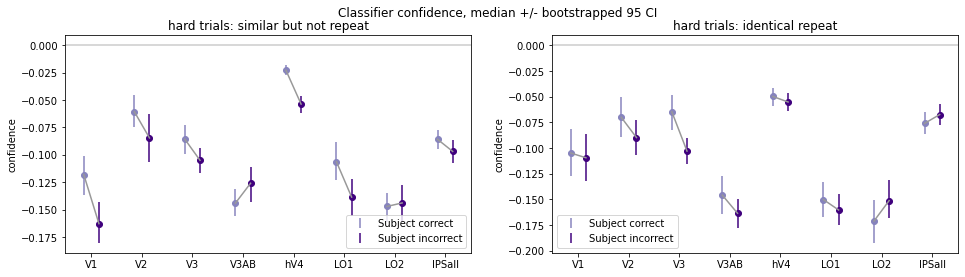

In [9]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(16,4))
    
for xi, name in enumerate(['hard trials: similar but not repeat', 'hard trials: identical repeat']):
   
    plt.subplot(1,2,xi+1)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([conf2_hard_sepcorrect_boot[:,:,xi,0,:], \
                                    conf2_hard_sepcorrect_boot[:,:,xi,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    # plt.ylim([-0.1, 0.4])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(name)
    
plt.suptitle('Classifier confidence, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'Classifier confidence, median +/- bootstrapped 95 CI')

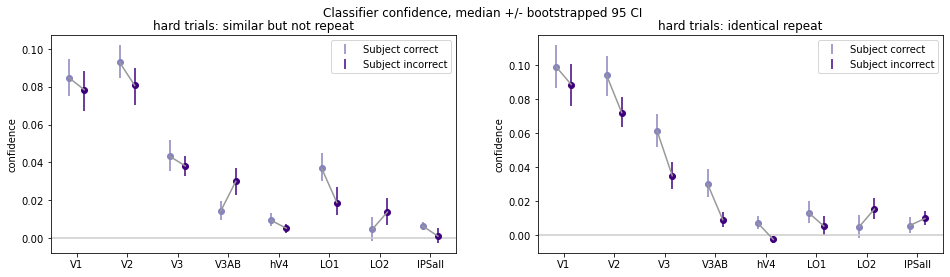

In [10]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(16,4))
    
for xi, name in enumerate(['hard trials: similar but not repeat', 'hard trials: identical repeat']):
   
    plt.subplot(1,2,xi+1)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([conf_hard_sepcorrect_boot[:,:,xi,0,:], \
                                    conf_hard_sepcorrect_boot[:,:,xi,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    # plt.ylim([-0.1, 0.4])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(name)
    
plt.suptitle('Classifier confidence, median +/- bootstrapped 95 CI')


In [14]:

ti = 3;
tt = 4;

acc_ongridtrials = np.zeros((n_subjects, n_rois, 1))
conf_ongridtrials = np.zeros((n_subjects, n_rois, 1))

acc_offgridtrials = np.zeros((n_subjects, n_rois, 1))
conf_offgridtrials = np.zeros((n_subjects, n_rois, 1))

acc_ongrid_repeat = np.zeros((n_subjects, n_rois, 1))
conf_ongrid_repeat = np.zeros((n_subjects, n_rois, 1))

acc_ongrid_norepeat = np.zeros((n_subjects, n_rois, 1))
conf_ongrid_norepeat = np.zeros((n_subjects, n_rois, 1))

acc_hard_repeat = np.zeros((n_subjects, n_rois, 1))
conf_hard_repeat = np.zeros((n_subjects, n_rois, 1))

acc_hard_norepeat = np.zeros((n_subjects, n_rois, 1))
conf_hard_norepeat = np.zeros((n_subjects, n_rois, 1))


for si, ss in enumerate(subjects):

    
    l = lab[ss][lab[ss]['task']==tt]

    is_main_grid = np.array(l['is_main_grid']==1)
    
    is_first = np.array(l['is_first_in_run']==True)
    
    is_repeat = np.array(l['is_repeat']==1)

    pts = np.array([l['ptx'], l['pty']]).T
    
    # nn_pts is nearest-neighbor to each pt in main grid
    nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T
    off_grid = np.any(pts!=nn_pts, axis=1)
    
    assert(np.all(off_grid==(~is_main_grid & ~is_repeat)))
    
    pt_inds = np.zeros((pts.shape[0],), dtype=int)
    for tr in range(pts.shape[0]):
        ind = np.argmin(np.sum((nn_pts[tr,:]-grid_pts)**2, axis=1))
        pt_inds[tr] = ind

    categ_actual = pt_inds
    
    for ri in range(n_rois):

        pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
        categ_pred = pred
        
        
        prob = dec_withintask['probs_all'][si][ri][ti]
        
        conf = np.zeros((prob.shape[0],))
        for pi in range(prob.shape[1]):
            inds = categ_actual==pi
            p_correct = prob[:,pi]
            p_incorrect = np.mean(prob[:,np.arange(16)!=pi], axis=1)
            conf[inds] = p_correct[inds] - p_incorrect[inds]
        
        
        # on grid trials
        inds = ~off_grid
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_ongridtrials[si,ri,0] = a;
        
        conf_ongridtrials[si,ri,0] = np.mean(conf[inds])
        

        # off grid trials 
        inds = off_grid
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_offgridtrials[si,ri,0] = a;

        conf_offgridtrials[si,ri,0] = np.mean(conf[inds])
        
        # repeat
        inds = ~off_grid & is_repeat & ~is_first
        # print('repeat: %d'%np.sum(inds))
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_ongrid_repeat[si,ri,0] = a;

        conf_ongrid_repeat[si,ri,0] = np.mean(conf[inds])
        
        
        # not-repeat
        inds = ~off_grid & ~is_repeat & ~is_first
        # print('not repeat: %d'%np.sum(inds))
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_ongrid_norepeat[si,ri,0] = a;

        conf_ongrid_norepeat[si,ri,0] = np.mean(conf[inds])
        
        
        
        # repeat
        inds = ~is_first & ~is_main_grid & is_repeat
        # print('repeat: %d'%np.sum(inds))
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_hard_repeat[si,ri,0] = a;

        conf_hard_repeat[si,ri,0] = np.mean(conf[inds])
        
        # not-repeat
        inds = ~is_first & ~is_main_grid & ~is_repeat
        # print('not repeat: %d'%np.sum(inds))
        
        a = np.mean(categ_pred[inds]==categ_actual[inds])
        acc_hard_norepeat[si,ri,0] = a;

        conf_hard_norepeat[si,ri,0] = np.mean(conf[inds])
        

Text(0.5, 1.0, 'Repeat task, accuracy at predicting nearest-neighbor')

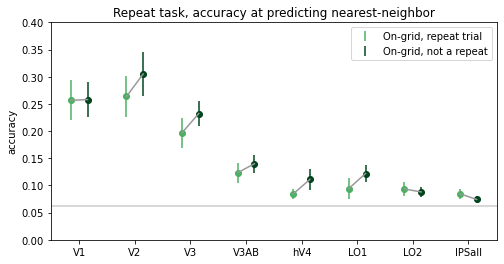

In [21]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(8,4))

colors = cm.Greens(np.linspace(0,1,6))[[3,5],:]

plt.axhline(1/16, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, vals in enumerate([acc_ongrid_repeat[:,:,0], \
                           acc_ongrid_norepeat[:,:,0]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]
   
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)
    mtmp.append(meanvals)
    
    plt.plot(x_ticks, meanvals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    mean_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot(ri+x_jitter, mean_vals,'-',color=[0.6, 0.6, 0.6])

plt.ylim([0, 0.4])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('accuracy')

plt.legend(lh,['On-grid, repeat trial','On-grid, not a repeat'])

plt.title('Repeat task, accuracy at predicting nearest-neighbor')

Text(0.5, 1.0, 'Repeat task, accuracy at predicting nearest-neighbor')

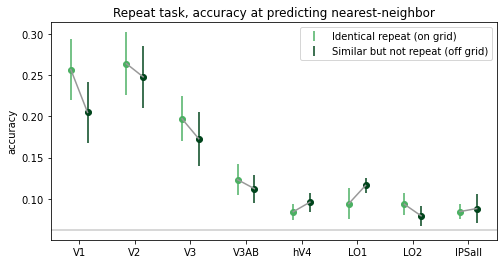

In [22]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(8,4))

colors = cm.Greens(np.linspace(0,1,6))[[3,5],:]

plt.axhline(1/16, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, vals in enumerate([acc_hard_repeat[:,:,0], \
                           acc_hard_norepeat[:,:,0]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]
   
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)
    mtmp.append(meanvals)
    
    plt.plot(x_ticks, meanvals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    mean_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot(ri+x_jitter, mean_vals,'-',color=[0.6, 0.6, 0.6])

# plt.ylim([0, 0.4])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('accuracy')

plt.legend(lh,['Identical repeat (on grid)','Similar but not repeat (off grid)'])

plt.title('Repeat task, accuracy at predicting nearest-neighbor')

Text(0.5, 1.0, 'Repeat task, accuracy at predicting nearest-neighbor')

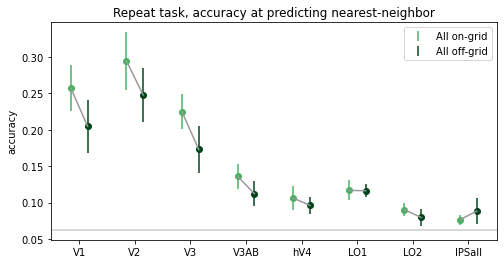

In [19]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(8,4))

colors = cm.Greens(np.linspace(0,1,6))[[3,5],:]

plt.axhline(1/16, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, avals in enumerate([acc_ongridtrials[:,:,0], \
                           acc_offgridtrials[:,:,0]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]
   
    meanvals = np.mean(avals, axis=0)
    semvals = np.std(avals, axis=0)/np.sqrt(n_subjects-1)
    mtmp.append(meanvals)
    
    plt.plot(x_ticks, meanvals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    mean_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot(ri+x_jitter, mean_vals,'-',color=[0.6, 0.6, 0.6])

# plt.ylim([0, 0.4])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('accuracy')

plt.legend(lh,['All on-grid','All off-grid'])

plt.title('Repeat task, accuracy at predicting nearest-neighbor')